In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import cv2
from PIL import Image
from dotenv import load_dotenv
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from skimage import io
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
# %matplotlib inline

In [3]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [4]:
# df = pd.read_csv('Songs folder/278k_song_labelled.csv')
df = pd.read_csv('Songs folder/kaggleMusicMoodFinal.csv')

In [5]:
# Assuming `df` is your DataFrame and it has the columns 'Mood', 'popularity', and 'id'
# Filter the DataFrame for the mood 'Sad'
sad_df = df[df['Mood'] == 'Calm']

# Sort by popularity in descending order
sad_df_sorted = sad_df.sort_values(by='popularity', ascending=False)

# Select the top 10 rows
top_10_sad = sad_df_sorted.head(10)

# Print the columns with song IDs and popularity
print(top_10_sad[['id', 'popularity', 'name', 'artists']])


                            id  popularity  \
116658  2bRKxuH1o7pTmb1y4GfdEc          85   
97479   129ldjjvnFfA7Ygc8ktYnh          81   
101582  65rkHetZXO6DQmBh3C2YtW          79   
101584  6H4B9gJD6eQlNoEh8q85pP          78   
3736    1LGFhRGycG5VI9cU8gFgVP          76   
138022  3AFEx7f9qxc6U59s27Tp1V          76   
3581    7svpAkwc6xaSxlbZ7V7JiS          76   
3586    506O2O13slCAUEo6w8aqr8          75   
8949    5pGBDKBaR63vuJ4g8ialcU          74   
4381    18lKp9uRyR2xJZFvg8ZWUC          74   

                                             name  \
116658  Clean White Noise - Loopable with no fade   
97479                            Soft Brown Noise   
101582                       White Noise - 500 hz   
101584                       White Noise - 145 hz   
3736                              Losing Interest   
138022                 White Noise Crashing Waves   
3581                           i was all over her   
3586                           I'll Keep You Safe   
8949            

In [6]:
spotify_df = df.copy()

In [7]:
spotify_df.shape

(156410, 27)

In [8]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [9]:
ohe_cols = 'popularity'

In [10]:
# create 5 point buckets for popularity 
spotify_df['bucket_popularity'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [11]:
spotify_df['consolidates_genre_lists_upd'] = spotify_df['consolidates_genre_lists'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])


In [12]:
spotify_df.head()


,Unnamed: 0.1,Unnamed: 0,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,Mood,bucket_popularity,consolidates_genre_lists_upd
0,0,0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989/06/15,0.0272,71.979,['조정현'],[],['조정현'],조정현그아픔까지사랑한거야,['classic_korean_pop'],Sad,6,[classic_korean_pop]
1,1,1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992/12/22,0.0395,200.341,['黑豹'],[],['黑豹'],黑豹DON'T BREAK MY HEART,"['chinese_indie', 'chinese_indie_rock']",Sad,7,"[chinese_indie, chinese_indie_rock]"
2,2,2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963/05/28,0.0443,85.936,['黃國隆'],[],['黃國隆'],黃國隆藝旦調,[],Sad,4,[]
3,3,3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963/05/28,0.0697,124.273,"['黃國隆', '王秋玉']",[],"['黃國隆', '王秋玉']",黃國隆草螟弄雞公,[],Sad,4,[]
4,4,4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963/05/28,0.0419,124.662,['黃國隆'],[],['黃國隆'],黃國隆思想起,[],Sad,4,[]


In [13]:
#simple function to create OHE features
#this gets passed later on
def One_Hot_Encode_Prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df



#function to build entire feature set
def Feature_Set_Using_TDiDF(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists_upd'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = One_Hot_Encode_Prep(df, 'explicit','exp')    
    year_ohe = One_Hot_Encode_Prep(df, 'year','year') * 0.5
    popularity_ohe = One_Hot_Encode_Prep(df, 'bucket_popularity','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final


def Get_Spotify_Playlist_DataFrame(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name
    
    #print(len(sp.playlist(id_dic[playlist_name])['tracks']['items']))

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    #playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist




def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()
    
    
    

def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas data00frame): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        playlist_features_not_in_dataframe (pandas dataframe): 
    """
    
    playlist_features_in_dataframe = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    playlist_features_in_dataframe = playlist_features_in_dataframe.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    playlist_features_not_in_dataframe = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = playlist_features_in_dataframe.sort_values('date_added', ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), playlist_features_not_in_dataframe





def Recommend_Playlist(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [14]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

# API credentials

In [15]:
load_dotenv('.env.local')

# Retrieve variables
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')
redirect_uri = os.getenv('SPOTIFY_REDIRECT_URI')

In [16]:


auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='playlist-read-private'))


In [17]:
token = util.prompt_for_user_token(scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)


In [18]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}

# Fetch current user's playlists
playlists = sp.current_user_playlists()

# Print the response for debugging
print("API Response:", playlists)

# Check if playlists are retrieved successfully
if 'items' in playlists:
    for playlist in playlists['items']:
        name = playlist.get('name')
        uri = playlist.get('uri')
        images = playlist.get('images', [])
        
        if name and uri and images:
            id_name[name] = uri.split(':')[2]
            list_photo[uri.split(':')[2]] = images[0]['url']
        else:
            print("Missing data in playlist item:", playlist)
else:
    print("No playlists found or API response is not in expected format.")

print("ID Name Dictionary:", id_name)
print("List Photo Dictionary:", list_photo)

API Response: {'href': 'https://api.spotify.com/v1/users/31lshxh66pvd7rsbfh3ohtk4wome/playlists?offset=0&limit=50', 'limit': 50, 'next': None, 'offset': 0, 'previous': None, 'total': 2, 'items': [{'collaborative': False, 'description': '', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0uDn2S2ZvV5vCTgN8Yt8f9'}, 'href': 'https://api.spotify.com/v1/playlists/0uDn2S2ZvV5vCTgN8Yt8f9', 'id': '0uDn2S2ZvV5vCTgN8Yt8f9', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67616d00001e028c1c216695b6a62f989b0d5e', 'width': None}], 'name': 'My Playlist #2', 'owner': {'display_name': 'Poon Tze Jian', 'external_urls': {'spotify': 'https://open.spotify.com/user/31lshxh66pvd7rsbfh3ohtk4wome'}, 'href': 'https://api.spotify.com/v1/users/31lshxh66pvd7rsbfh3ohtk4wome', 'id': '31lshxh66pvd7rsbfh3ohtk4wome', 'type': 'user', 'uri': 'spotify:user:31lshxh66pvd7rsbfh3ohtk4wome'}, 'primary_color': None, 'public': True, 'snapshot_id': 'AAAAAsM5Ugb2tU/vuRDurEt950/LvOGO', 'tracks': {'href

In [19]:
id_name


{'My Playlist #2': '0uDn2S2ZvV5vCTgN8Yt8f9', 'EDM': '4MA2avnMXFFUNk2kE5JHsN'}

In [20]:
def get_recommendation_preference(mood):
    """ 
    Get recommendation preference from the user based on the mood determined by the model.
    
    Parameters:
        mood (str): Mood determined by the model
    
    Returns:
        str: recommendation_type
    """
    recommendation_type = None
    
    if mood == "Happy":
        recommendation_type = input("Do you prefer 'happy' music to enjoy yourself or 'calm' music to keep you from getting carried away? ").strip()
        while recommendation_type not in ["happy", "calm"]:
            print("Invalid choice. Please choose either 'happy' or 'calm'.")
            recommendation_type = input("Do you prefer 'happy' music or 'calm' music? ").strip()
    elif mood in ["Sad"]:
        recommendation_type = input("Do you prefer more 'sad' music for you to vent or 'calm' music to calm you down? ").strip()
        while recommendation_type not in ["sad", "calm"]:
            print("Invalid choice. Please choose either 'sad' or 'calm'.")
            recommendation_type = input("Do you prefer 'sad' music or 'calm' music? ").strip()
            
    return recommendation_type


In [21]:
def ChooseDataset(x, recommendation_type):
    if x == "Disgust":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Calm'])]
    if x == "Angry":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
    if x == "Fear":
        return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Happy":
        if recommendation_type == "happy":
            return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy'])]
        elif recommendation_type == "gentle":
            return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Sad":
        if recommendation_type == "sad":
            return spotify_df[spotify_df['Mood'].isin(['Sad'])]
        elif recommendation_type == "calm":
            return spotify_df[spotify_df['Mood'].isin(['Calm'])]
    if x == "Surprise":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Sad'])]
    return spotify_df

In [22]:
def Recommend_Top40(x, recommendation_type):
    try:
        # Choose the dataset
        O_df = ChooseDataset(x, recommendation_type)
        
        # Perform feature engineering
        complete_feature_set = Feature_Set_Using_TDiDF(O_df, float_cols=float_cols)
        
        # Collect playlist data from Spotify
        one_playlist_from_spotify = Get_Spotify_Playlist_DataFrame('EDM', id_name, O_df)
        
        # Generate playlist features
        features_in_the_playlist, features_not_in_the_playlist = generate_playlist_feature(complete_feature_set, one_playlist_from_spotify, 1.09)
        
        # Get top 40 recommendations
        top40_recommendation = Recommend_Playlist(spotify_df, features_in_the_playlist, features_not_in_the_playlist)
        
        # Visualize the recommendations
        visualize_songs(top40_recommendation)
    
    except Exception as e:
        print(f"An error occurred: {e}")

In [23]:
from tensorflow.keras.models import load_model

model = load_model('Trained Model/CLCM_model.keras')

In [24]:
face_casecade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def moodNamePrintFromLabel(n):
    if n == 0: result = "Angry"
    elif n == 1: result = "Disgust"
    elif n == 2: result = "Fear"
    elif n == 3: result = "Happy"
    elif n == 4: result = "Sad"
    elif n == 5: result = "Surprise"
    elif n == 6: result = "Neutral"
        
    return result

def imageToMoodDetection(img_path):
    img = cv2.imread(img_path)
    Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

    # Ensure at least one face is detected
    if len(faces) == 0:
        print("No faces detected")
        return

    for (x, y, w, h) in faces:
        # Extract face region
        face_region = Gray_img[y:y+h, x:x+w]
        
        # Convert grayscale to RGB
        face_region_rgb = cv2.cvtColor(face_region, cv2.COLOR_GRAY2RGB)
        
        # Resize and preprocess the face image
        resized_img = cv2.resize(face_region_rgb, (224, 224), interpolation=cv2.INTER_AREA)
        resized_img = np.reshape(resized_img, (1, 224, 224, 3)) / 255.0
        
        # Make prediction with the model
        result = np.argmax(model.predict(resized_img), axis=-1)
        mood = moodNamePrintFromLabel(result[0])
        print(f"Detected mood: {mood}")

In [25]:
Image_path = 'Test image/Testing5.webp'

In [26]:
print(id_name)

{'My Playlist #2': '0uDn2S2ZvV5vCTgN8Yt8f9', 'EDM': '4MA2avnMXFFUNk2kE5JHsN'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Detected mood: Sad


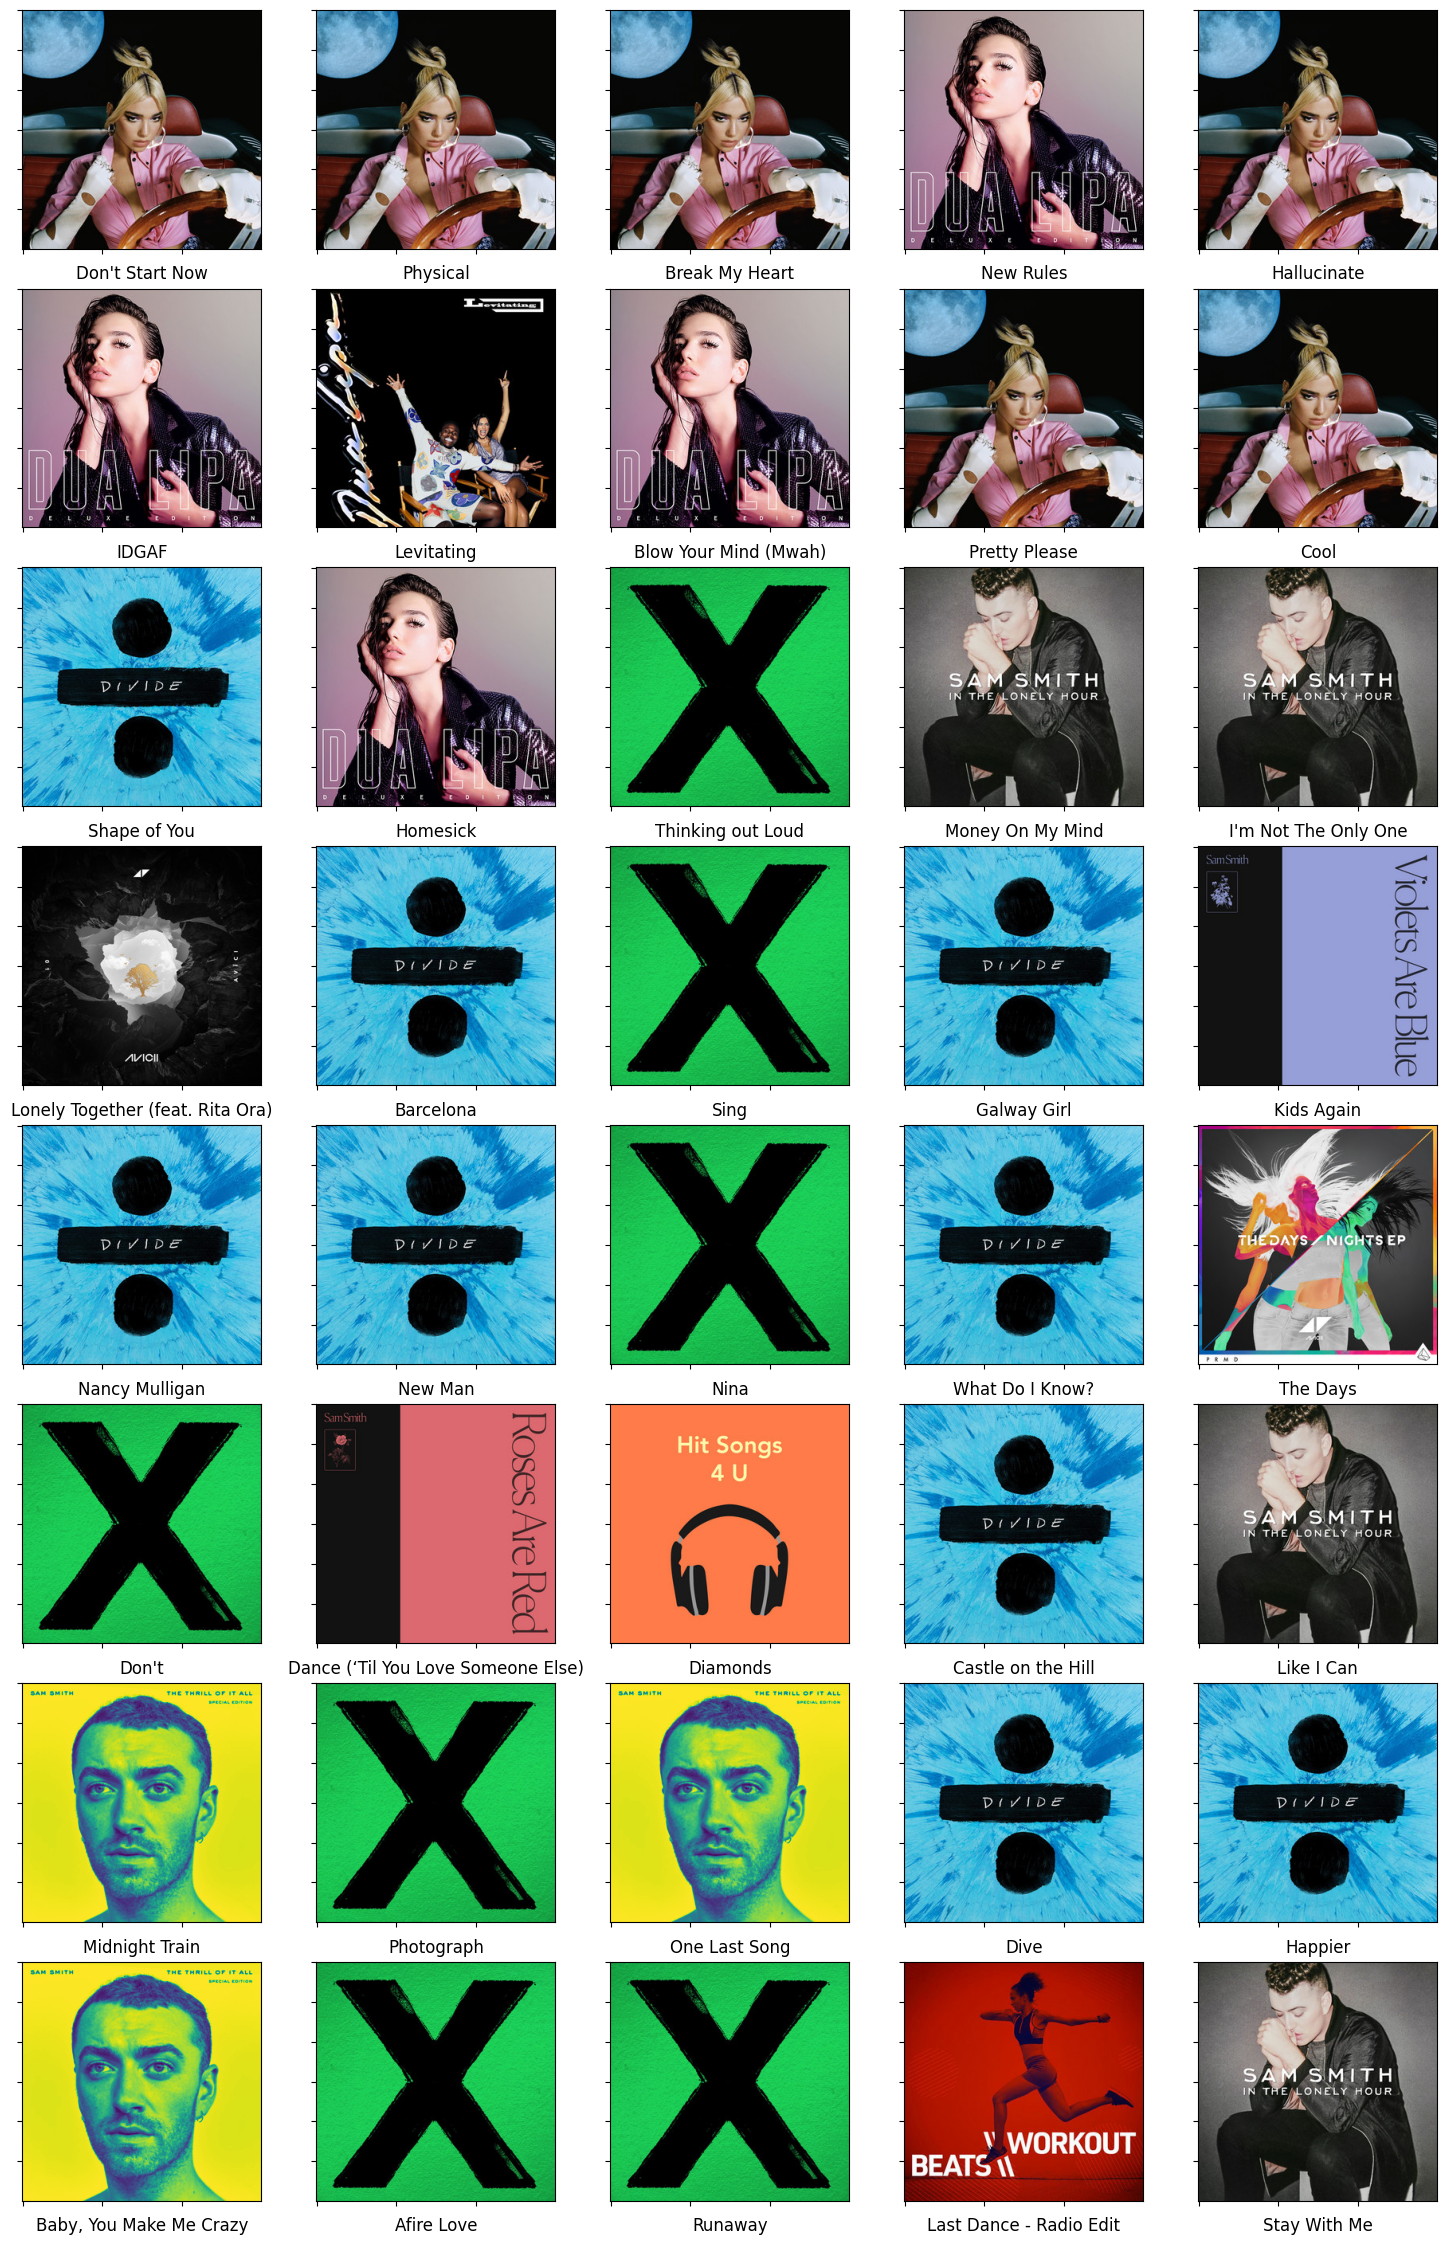

In [27]:
# Get the mood from the image
mood = imageToMoodDetection(Image_path)

# Get the recommendation preference based on the detected mood
recommendation_type = get_recommendation_preference(mood)

# Call the Recommend_Top40 function with both the mood and recommendation type
Recommend_Top40(mood, recommendation_type)
